# Creating local estimates of boundary of basin of attraction

## Model a dynamical system

We model the Lorenz system, which consists of the following three ODEs: 

$$x'=\sigma(y-x) \\
y'=rx-y-xz \\
z'=xy-\beta z$$

In [1]:
import numpy as np
import math
from scipy.integrate import solve_ivp

We set some parameters and do a test simulation to observe the convergence process to a stable equilibrium. The simulation code is referenced from https://github.com/scipython/scipython-maths/blob/master/lorenz/lorenz.py

In [2]:
# Lorenz parameters and initial conditions.
sigma, beta, r = 10, 8/3, 10
x0, y0, z0 = 0, 1, 1.05

# Maximum time point and total number of time points.
tmax, n = 1500, 100000

In [3]:
def lorenz(t, X, sigma, beta, r):
    """The Lorenz equations."""
    x, y, z = X
    xp = sigma*(y - x)
    yp = r*x - y - x*z
    zp = -beta*z + x*y
    return xp, yp, zp

In [4]:
# Integrate the Lorenz equations.
soln = solve_ivp(lorenz, (0, tmax), (x0, y0, z0), args=(sigma, beta, r),dense_output=True)
# Interpolate solution onto the time grid, t.
t = np.linspace(0, tmax, n)
x, y, z = soln.sol(t)

After numerically solving the problem, we plot the trajectory.

In [64]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [32]:
WIDTH, HEIGHT, DPI = 1000, 750, 100

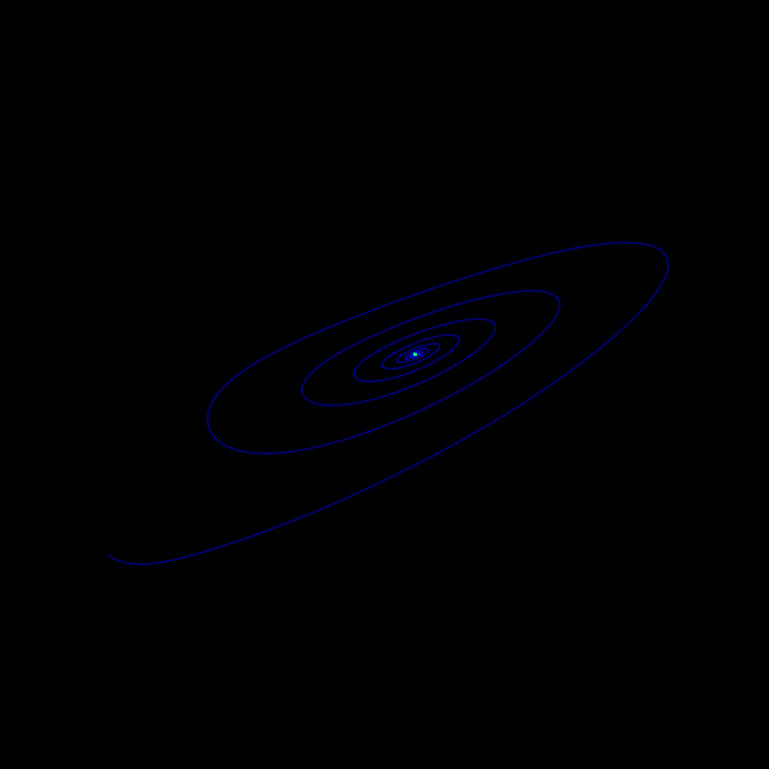

In [33]:
# Plot the Lorenz attractor using a Matplotlib 3D projection.
fig = plt.figure(facecolor='k', figsize=(WIDTH/DPI, HEIGHT/DPI))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('k')
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# Make the line multi-coloured by plotting it in segments of length s which
# change in colour across the whole time series.
s = 10
cmap = plt.cm.winter
for i in range(0,n-s,s):
    ax.plot(x[i:i+s+1], y[i:i+s+1], z[i:i+s+1], color=cmap(i/n), alpha=0.4)

# Remove all the axis clutter, leaving just the curve.
#ax.set_axis_off()

plt.savefig('lorenz_win.png', dpi=DPI)
plt.show()

By the setting of parameters, the system has two stable equilibriums. 

By checking the trace of the trajectory, we could observe that the flow converges to one of them.

## Simulation to collect data

We now form a dataset for training and testing with the following way: We randomly select initial conditions $(x_{0},y_{0},z_{0}) \in (-50,50)\times (-50,50) \times (-50,50)$ and compute the trajectories. We fix a stable equilibrium of interest, and label the points as 1 or -1 depending on whether the trajectory converges to that equilibrium. With the above set of parameters, we have that $(\sqrt{24}, \sqrt{24}, 9)$ is a stable equilibrium. We therefore obtain a dataset by simulating the trajectory of 500 sample points. If the trajectory is attracted, we label it as +1, otherwise -1.

In [60]:
def euclidean_distance(point1, point2):
    point1, point2 = np.array(point1), np.array(point2)
    return np.sqrt(np.sum((point1 - point2) ** 2))
lorenz_attractor = (math.sqrt(24), math.sqrt(24), 9)

In [61]:
# Check if the trajectory is attracted to the concerned Lorenz attractor
def is_attracted(x, y, z):
    return euclidean_distance((x, y, z), lorenz_attractor) < 0.01

In [62]:
## Implement the simulation process and decide if the trajectory is attracted by the Lorenz attractor
def simulation(x0 ,y0 ,z0):
    tmax, n = 1500, 100000
    soln = solve_ivp(lorenz, (0, tmax), (x0, y0, z0), args=(sigma, beta, r),dense_output=True)
    t = np.linspace(0, tmax, n)
    x, y, z = soln.sol(t)
    return is_attracted(x[n-1], y[n-1], z[n-1])

In [65]:
print(simulation(0, 1, 1.05))

True


In [38]:
def generate_random_points():
    x0 = np.random.uniform(-50, 50)
    y0 = np.random.uniform(-50, 50)
    z0 = np.random.uniform(-50, 50)
    return x0, y0, z0

In [39]:
import pandas as pd

# Create the dataset
df = pd.DataFrame(columns=['x0', 'y0', 'z0', 'attracted'])
for i in range(100000):
    x0, y0, z0 = generate_random_points()
    attracted_result = simulation(x0, y0, z0)
    attracted_result = 1 if attracted_result else -1  # map True to 1 and False to -1
    df.loc[i] = [x0, y0, z0, attracted_result]
    if i % 1000 == 0:  # print progress every 1000 iterations
        print(f"Progress: {i}/100000")

# Save the DataFrame to a CSV file
df.to_csv('dataset_large.csv', index=False)

Progress: 0/100000
Progress: 1000/100000
Progress: 2000/100000
Progress: 3000/100000
Progress: 4000/100000
Progress: 5000/100000
Progress: 6000/100000
Progress: 7000/100000
Progress: 8000/100000
Progress: 9000/100000
Progress: 10000/100000
Progress: 11000/100000
Progress: 12000/100000
Progress: 13000/100000
Progress: 14000/100000
Progress: 15000/100000
Progress: 16000/100000
Progress: 17000/100000
Progress: 18000/100000
Progress: 19000/100000
Progress: 20000/100000
Progress: 21000/100000
Progress: 22000/100000
Progress: 23000/100000
Progress: 24000/100000
Progress: 25000/100000
Progress: 26000/100000
Progress: 27000/100000
Progress: 28000/100000
Progress: 29000/100000
Progress: 30000/100000
Progress: 31000/100000
Progress: 32000/100000
Progress: 33000/100000
Progress: 34000/100000
Progress: 35000/100000
Progress: 36000/100000
Progress: 37000/100000
Progress: 38000/100000
Progress: 39000/100000
Progress: 40000/100000
Progress: 41000/100000
Progress: 42000/100000
Progress: 43000/100000
P

## Reproduction of Shena et.al approach using deep neural network

With dataset generated, we will train a neural network to perform logistic regression by minimizing cross-entropy loss.

In [66]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

In [67]:
## Load the dataset
class LorenzDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = torch.tensor([self.data.iloc[idx].x0, self.data.iloc[idx].y0, self.data.iloc[idx].z0]).float()
        label = torch.tensor(self.data.iloc[idx].attracted).float()
        return features, label
    
dataset = LorenzDataset('dataset_large.csv')

dataset_train, dataset_test = torch.utils.data.random_split(dataset, [80000, 20000])

dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

In [68]:
features, labels = next(iter(dataloader_train))
print(features, labels)

tensor([[ 37.3326,  16.5492, -14.5861],
        [-43.1415,  30.2414,  12.8765],
        [ 46.0517,  25.3404, -41.7467],
        [ -3.1700,   8.7397,  -4.9244],
        [-23.3411,   3.1427,  45.1518],
        [ 47.6558, -44.0941, -21.0363],
        [ 35.2710,  -1.4970,  27.0604],
        [ 13.6984,  49.6116, -39.1220],
        [-37.7283,   2.1661,  45.3200],
        [  4.7741,  13.9720, -45.7685],
        [ 38.7399,  17.2911,  31.4361],
        [  5.8882, -19.3497, -12.8768],
        [-24.9709, -48.0894,   3.6377],
        [  7.5305, -13.3600,   9.4539],
        [ 19.9878, -18.9177,  22.1868],
        [-24.4941,  43.5281,  26.1263],
        [-32.7732, -17.3541,  -3.4540],
        [ 10.5362,  19.9147, -25.9713],
        [ 37.8950,  30.0925,   0.6251],
        [ 25.1730,   0.9658, -25.9774],
        [ 12.9910,   3.9789, -43.1639],
        [-16.9503, -28.8607, -11.5774],
        [ 31.4228, -47.9733, -24.1205],
        [-14.7698,   6.6959,  32.1463],
        [ 18.0876, -48.0968,  42.4699],


In [69]:
## Define the neural network. The complexity of the network is a hyperparameter.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3,128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x
    
net = Net()

In [70]:
## Set up loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [72]:
# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
net = net.to(device)
criterion = criterion.to(device)

# Train the network
for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    mini_batch_count = 0
    for features, labels in dataloader_train:  # use the DataLoader here
        # Convert labels from -1 or 1 to 0 or 1
        labels = ((labels + 1) / 2).float()

        # Reshape labels to match the output shape
        labels = labels.view(-1)

        # Move the features and labels to the device
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(features).view(-1) 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        mini_batch_count += 1

    print('Finished training for epoch %d, loss: %.3f' % (epoch + 1, running_loss / mini_batch_count))

Finished training for epoch 1, loss: 0.591
Finished training for epoch 2, loss: 0.425
Finished training for epoch 3, loss: 0.273
Finished training for epoch 4, loss: 0.215
Finished training for epoch 5, loss: 0.186
Finished training for epoch 6, loss: 0.171
Finished training for epoch 7, loss: 0.160
Finished training for epoch 8, loss: 0.151
Finished training for epoch 9, loss: 0.146
Finished training for epoch 10, loss: 0.143
Finished training for epoch 11, loss: 0.134
Finished training for epoch 12, loss: 0.135
Finished training for epoch 13, loss: 0.130
Finished training for epoch 14, loss: 0.128
Finished training for epoch 15, loss: 0.124
Finished training for epoch 16, loss: 0.124
Finished training for epoch 17, loss: 0.120
Finished training for epoch 18, loss: 0.116
Finished training for epoch 19, loss: 0.118
Finished training for epoch 20, loss: 0.118
Finished training for epoch 21, loss: 0.113
Finished training for epoch 22, loss: 0.114
Finished training for epoch 23, loss: 0.1

Accuracy: 0.9626500010490417


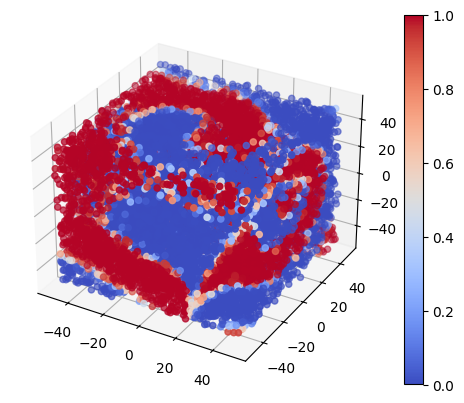

In [79]:
## Test the network and plot the results
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

features_list = []
labels_list = []
probability_list = []
predictions_list = []
acc = Accuracy(task = 'binary')

dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

with torch.no_grad():
    for features, labels in dataloader_test:
        features = features.to(device)
        labels = labels.to(device)
        labels = ((labels + 1) / 2).float()
        probability = net(features)
        outputs = (probability >= 0.5).float()
        outputs = outputs.squeeze(0)

        acc.update(outputs, labels)

        # Move features, labels, and outputs to CPU and convert them to numpy arrays
        features_list.append(features.cpu().numpy())
        labels_list.append(labels.cpu().numpy())
        probability_list.append(probability.cpu().numpy())
        predictions_list.append(outputs.cpu().numpy())
accuracy = acc.compute()
print(f'Accuracy: {accuracy}')

# Concatenate all batches
features = np.concatenate(features_list, axis=0)
labels = np.concatenate(labels_list, axis=0)
probability = np.concatenate(probability_list, axis=0)
predictions = np.concatenate(predictions_list, axis=0)

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the features colored by the predictions
scatter = ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=probability, cmap='coolwarm')

# Add a color bar
plt.colorbar(scatter)

plt.show()

In [80]:
## Save the model
torch.save(net.state_dict(), 'lorenz_model_mac.pth')

In [81]:
## Code to reload the model
net = Net()

# Load the model
net.load_state_dict(torch.load('lorenz_model_mac.pth'))

<All keys matched successfully>

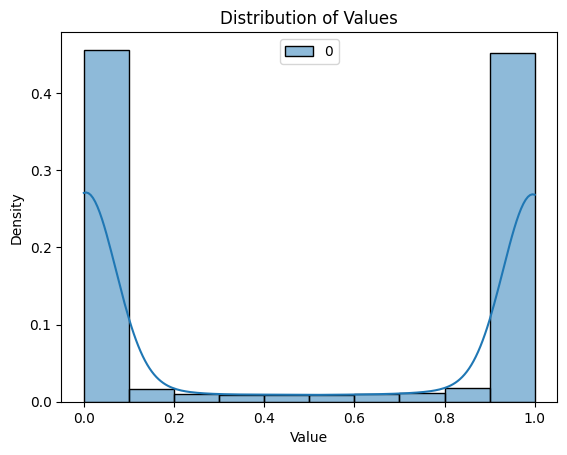

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.histplot(probability, stat="probability", bins=10, kde=True)
plt.title('Distribution of Values')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

Accuracy: 0.5022000074386597


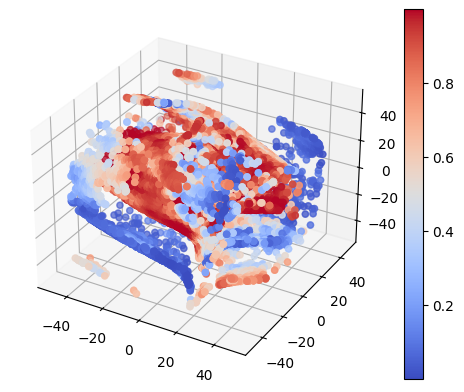

In [83]:
## Test the network against near-boundary points
dataset_test_near_boundary = LorenzDataset('dataset_near.csv')
dataloader_test_near_boundary = DataLoader(dataset_test_near_boundary, batch_size=32, shuffle=False)

features_list_near = []
labels_list_near = []
probability_list_near = []
predictions_list_near = []
acc = Accuracy(task = 'binary')


with torch.no_grad():
    for features, labels in dataloader_test_near_boundary:
        features = features.to(device)
        labels = labels.to(device)
        labels = ((labels + 1) / 2).float()
        probability = net(features)
        outputs = (probability >= 0.5).float()
        outputs = outputs.squeeze()

        acc.update(outputs, labels)

        # Move features, labels, and outputs to CPU and convert them to numpy arrays
        features_list_near.append(features.cpu().numpy())
        labels_list_near.append(labels.cpu().numpy())
        probability_list_near.append(probability.cpu().numpy())
        predictions_list_near.append(outputs.cpu().numpy())
accuracy = acc.compute()
print(f'Accuracy: {accuracy}')

# Concatenate all batches
features_near = np.concatenate(features_list_near, axis=0)
labels_near = np.concatenate(labels_list_near, axis=0)
probability_near = np.concatenate(probability_list_near, axis=0)
predictions_near = np.concatenate(predictions_list_near, axis=0)

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the features colored by the predictions
scatter = ax.scatter(features_near[:, 0], features_near[:, 1], features_near[:, 2], c=probability_near, cmap='coolwarm')

# Add a color bar
plt.colorbar(scatter)

plt.show()


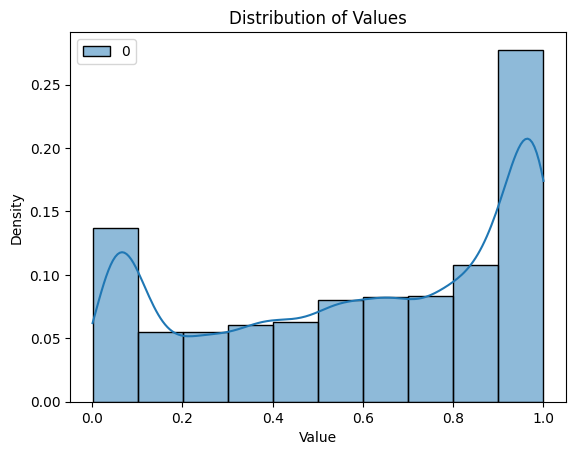

In [85]:
sns.histplot(probability_near, stat="probability", bins=10, kde=True)
plt.title('Distribution of Values')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

In [86]:
## Save the model
torch.save(net.state_dict(), 'lorenz_model_mac.pth')

We could see that the clasicial deep neural network approach does not classify near-boundary points well. The high accuracy is mainly due to the majority of points further from the boundary. Therefore, if we could find a classifier that retains high accuracy and still predicts near-boundary points well, then we find an improved estimate of basin boundary.